<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#[Ensemble-Classifier-직접-구현]" data-toc-modified-id="[Ensemble-Classifier-직접-구현]-1"><font color="blue">[Ensemble Classifier 직접 구현]</font></a></span></li><li><span><a href="#[Bagging]" data-toc-modified-id="[Bagging]-2"><font color="blue">[Bagging]</font></a></span></li><li><span><a href="#[RandomForest]" data-toc-modified-id="[RandomForest]-3"><font color="blue">[RandomForest]</font></a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.0.1">RandomForestRegressor</a></span></li></ul></li></ul></li><li><span><a href="#[Boosting]" data-toc-modified-id="[Boosting]-4"><font color="blue">[Boosting]</font></a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Boosting의-작동-원리" data-toc-modified-id="Boosting의-작동-원리-4.0.0.1">Boosting의 작동 원리</a></span></li><li><span><a href="#AdaBoost" data-toc-modified-id="AdaBoost-4.0.0.2">AdaBoost</a></span></li><li><span><a href="#GradientBoosting" data-toc-modified-id="GradientBoosting-4.0.0.3">GradientBoosting</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#[Stacking]" data-toc-modified-id="[Stacking]-5"><font color="blue">[Stacking]</font></a></span></li><li><span><a href="#[SHAP-Value]" data-toc-modified-id="[SHAP-Value]-6"><font color="blue">[SHAP Value]</font></a></span></li></ul></div>

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
sns.set_context("notebook", font_scale=1.5)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score , cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# <font color='blue'>[Ensemble Classifier 직접 구현]</font>

In [71]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    # BaseEstimator와 ClassifierMixin이 포함하는 기능은
        # get_params, set_params, score 메서드 등이다.
    """
    매개변수
    ------
    classifiers: 배열 타입, 크기 = [n_classifiers]
      앙상블에 사용할 분류기
    
    vote: str, {'classlabel', 'probability'}
      'classlabel' 이면 다수인 클래스 레이블로 예측 반환
      'probability' 이면 예측을 확률값으로 반환
    
    weights: array-like, 크기 = [n_classifiers]
      'int' 또는 'float' 값의 리스트가 주어지면 분류기가 이 중요도로 가중치된다.
    """
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for
                                  key, value in
                                  _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote는 'probability' 또는 'classlabel'이어야 합니다."\
                             "; (vote=%r)이 입력되었습니다."
                             % self.vote)
            
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError("분류기와 가중치의 개수는 같아야 합니다."
                             "; 가중치 %d개, 분류기 %d 개"
                             % (len(self.weights), len(self.classifiers)))
            
        # self.predict 메서드에서 np.argmax를 호출할 때
            # 클래스 레이블이 0부터 시작되어야 하므로 LabelEncoder 사용
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,
                                        self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
            
        else:
            predictions = np.asarray([clf.predict(X)
                                      for clf in
                                      self.classifiers_]).T
            
            maj_vote = np.apply_along_axis(
                            lambda x:
                            np.argmax(np.bincount(x,
                                      weights=self.weights)),
                            axis=1,
                            arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassifier,
                         self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in\
                    six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(
                        step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [76]:
# iris data 에 대한 개별 분류기(DT, KNN, LR) 성능 비교
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.5,
                         random_state=1, stratify=y)

In [79]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy',
                              random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-겹 교차 검증:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train,
                             y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-겹 교차 검증:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [80]:
# 직접 만든 분류기 실행
mv_clf = MajorityVoteClassifier(
                classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train,
                             y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority Voting]


# <font color='blue'>[Bagging]</font>
- 배깅은 위에서 구현한 MajorityVoteClassifier와 매우 밀접하게 작동하는 기법인데, 차이점은 개별 분류기를 동일한 훈련 데이터셋으로 학습하는 것이 아니라 원본 훈련 데이터셋에서 부트스트랩 샘플(중복을 허용한 랜덤 샘플)을 뽑아서 사용한다. (=> 그래서 배깅을 'bootstrap aggregating'이라고도 한다)
    - 랜덤 포레스트는 개별 결정 트리를 학습할 때 '랜덤하게 특성의 부분 집합을 선택하는' 배깅의 특별한 경우다.
    - 각각의 부트스트랩 샘플은 대략 63.2%의 unique values로 구성되게 된다.
    - "Bagging can improve the accuracy of unstable models that tend to overfit."

# <font color='blue'>[RandomForest]</font>

- 여러 개의 (깊은) 결정 트리의 평균을 내는 것이다.
- 개개의 트리는 분산이 높은 문제가 있지만, 앙상블 기법을 사용하면 일반화 성능을 높이고 과대적합의 위험을 줄여준다.<br><br>

1. n개의 랜덤한 부트스트랩 샘플을 뽑는다. (훈련 데이터셋에서 중복을 허용하면서 랜덤하게 n개의 샘플을 선택한다)
2. 부트스트랩 샘플에서 결정 트리를 학습한다. 각 노드에서 다음과 같이 한다.
    - 중복을 허용하지 않고 랜덤하게 d개의 특성을 선택한다.
    - 정보 이득과 같은 목적 함수를 기준으로 최선의 분할을 만드는 특성을 사용해서 노드를 분할한다.
3. 단계 1~2를 k번 반복한다.
4. 각 트리의 예측을 모아 majority voting으로 클래스 레이블을 할당한다.

> 랜덤 포레스트는 결정 트리만큼 해석이 쉽진 않지만 하이퍼파라미터 튜닝에 많은 노력을 기울이지 않아도 된다는 장점이 있다. (일반적으로 가지치기를 할 필요가 없다.) 신경써야 하는 파라미터는 단계 3번의 랜덤 포레스트가 만들 트리 개수다. 보통 트리 개수가 많을수록 계산 비용이 증가하고 분류기의 성능이 좋아진다.<br>

- Random Forest에서 최적화할 만한 다른 파라미터는 부트스트랩 샘플 크기 $n$이랑, 각 분할에서 무작위로 선택할 특성 개수 $d$이다.
    - 샘플 크기가 작아지면 => 개별 트리의 다양성 증가하고 => 과대적합 영향이 줄어들지만 랜덤 포레스트의 전체적인 성능도 줄어든다.
    - 샘플 크기가 늘어나면 과대적합 가능성이 늘어난다.
    - 보통은 부트스트랩 샘플 크기를 원본 훈련 데이터셋의 샘플 개수와 동일하게 한다.
    - 분할에 사용할 특성 개수 $d$는 훈련 데이터셋에 있는 전체 개수보다 작게 지정하곤 한다. 훈련 데이터셋 특성 개수의 제곱근을 취하기도 한다.

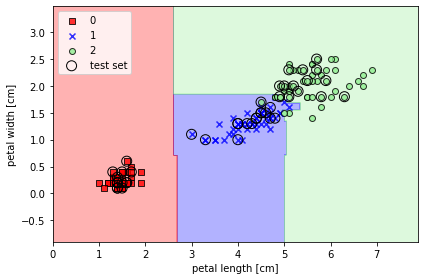

In [68]:
# 실습
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='gini',
                               n_estimators=25,
                               random_state=1,
                               n_jobs=2)
    # n_estimators는 생성할 결정 트리 개수; n_jobs는 컴퓨터의 멀티 코어를 몇 개나 사용할지 지정
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined,
                     classifier=forest, test_idx=range(105,150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

### RandomForestRegressor

In [82]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [7]:
df = pd.read_csv('../pos_bigdata/3data/체질검사.csv')

df_x = df.drop('FAT', axis=1)
df_y = df['FAT']

X_train, X_test, y_train, y_test = \
    train_test_split(df_x, df_x, test_size=0.3)

In [15]:
from sklearn.ensemble import RandomForestRegressor
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, refit=True)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [58]:
scores_df = pd.DataFrame(rf_random.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score']].sort_values(by=['rank_test_score'])

,params,mean_test_score,rank_test_score
25,"{'n_estimators': 400, 'min_samples_split': 2, ...",0.695176,1
17,"{'n_estimators': 1000, 'min_samples_split': 2,...",0.688957,2
45,"{'n_estimators': 1000, 'min_samples_split': 2,...",0.688705,3
49,"{'n_estimators': 600, 'min_samples_split': 2, ...",0.685175,4
31,"{'n_estimators': 800, 'min_samples_split': 2, ...",0.684976,5
...,...,...,...
51,"{'n_estimators': 2000, 'min_samples_split': 10...",0.483063,96
18,"{'n_estimators': 1800, 'min_samples_split': 10...",0.482981,97
83,"{'n_estimators': 800, 'min_samples_split': 10,...",0.482968,98
44,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.430434,99


In [60]:
export_graphviz(rf1.estimator_[0],
                out_file='rfr_0.dot',
                feature_names=X_train.columns,
                impurity=True, filled=True)
with open('rfr_0.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot.graph))

AttributeError: 'RandomForestRegressor' object has no attribute 'estimator_'

In [62]:
rf1.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=400)>

In [65]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=400)

In [66]:
rf1 = rf_random.best_estimator_

In [70]:
df_importance = pd.DataFrame()
df_importance['Feature'] = X_train.columns
df_importance['Importance'] = rf1.feature_importances_

df_importance.sort_values(by=['Importance'], ascending=False)

,Feature,Importance
1,WEIGHT,0.219858
4,CHEST,0.148725
6,HIP,0.131409
5,ABDOMEN,0.122168
7,THIGH,0.088489
8,KNEE,0.066195
0,AGE,0.053736
3,NECK,0.052918
10,BICEPS,0.027760
12,WRIST,0.026710


# <font color='blue'>[Boosting]</font>

> **Boosting이란.. it means boosting 'weak learners' to 'strong learners.'** => 부스팅은 iterative process이다: *각각의 iteration마다 the training set is reweighted based on errors of weak learners.*
> - Adaptive Boosting과 Gradient Boosting의 차이는:
    - on how the weights are updated;
    - and on how the classifiers are combined.

#### Boosting의 작동 원리
1. 훈련 데이터셋 $D$에서 중복을 허용하지 않고 랜덤한 부분 집합 $d_1$를 뽑아 약한 학습기 $C_1$(예를 들어 깊이가 1인 결정트리)를 훈련한다.
2. 훈련 데이터셋에서 중복을 허용하지 않고 두 번째 랜덤한 훈련 부분 집합 $d_2$를 뽑고 이전에 잘못 분류된 샘플의 50%를 더해서 약한 학습기 $C_2$를 훈련한다.
3. 훈련 데이터셋 $D$에서 $C_1$과 $C_2$에서 잘못 분류한 훈련 샘플 $d_3$를 찾아 세 번째 약한 학습기인 $C_3$를 훈련한다.
4. 약한 학습기 $C_1$, $C_2$, $C_3$를 다수결 투표로 연결한다.

#### AdaBoost
training set의 가중치를 weak learner의 에러에 기반해 계속 업데이트하고, 모든 weak learner의 예측을 majority voting으로 합친다.


#### GradientBoosting
In contrast to AdaBoost, the output of gradient boosting is an additive models of multiple weak learners. (rather than the majority voting of the ensemble of models)
- GB를 가동하면, 그 첫 번째 모델은 예를 들어 깊이가 1인 결정트리이고, 마지막 결과물은 깊이가 훨씬 더 깊은 결정트리가 되는 것이다.
- GB의 작동 방식
    1. Construct a base tree (just the root node).
    2. Build next tree based on errors of the previous tree.
    3. Combine tree from step 1 with trees from step 2. Go to step 2.
    

- AdaBoost와 달리 이전의 약한 학습기가 만든 '잔차오차(residual error)를 학습하는 새로운 학습기를 추가한다.

- 장점
    - 하이퍼파라미터 조정이 쉽고 성능이 뛰어남
    - 데이터 scale 변환이 불필요
- 단점
    - 개별 트리 분석이 어렵고, 트리 개수가 늘어날수록 과대적합되는 경향이 있음
    - 차원이 크고 희소한 데이터에서는 성능이 미흡
    - 모델 성능이 하이퍼파라미터, 특히 학습률에 민감함

# <font color='blue'>[Stacking]</font>

# <font color='blue'>[SHAP Value]</font>